In [30]:
import pandas as pd
import pickle
import seaborn as sns

from functools import reduce
from itertools import product
from pathlib import Path

In [89]:
# Load dataset
with open('../../datasets/Min_2020_n558/cleaned_dataset.pkl', 'rb') as f:
    clean_dataset = pickle.load(f)
    clean_dataset.reset_index(drop=True, inplace=True)

# Root results directory
results_root = Path("../../results/target_PCE")

# Enumerate combinations
representations = ["ECFP", "mordred"]
# filters = ["device architecture"]
models = ["HGB",
          "NGB",
          # "NN",
          "RF"]

In [91]:
# Filtering function
def detect_outliers(true: pd.DataFrame, pred: pd.DataFrame, threshold):
    diff = abs(pred.sub(true["calculated PCE (%)"], axis=0))
    mask = (diff > threshold).any(axis=1)
    outliers = pred[mask]
    return outliers

# Define a function to perform consecutive merges
def merge_all_dataframes(dataframes):
    merged_df = dataframes[0]
    for df in dataframes[1:]:
        merged_df = pd.merge(merged_df, df, left_index=True, right_index=True, how="inner")
        
    merged_df = merged_df.loc[:,~merged_df.columns.duplicated()]
    return merged_df

def get_common_outliers(threshold) -> list[float]:
    outliers_list = []
    combinations = list(product(representations, models))
    for combination in combinations:
        representation, model = combination
        # print(f"Representation: {representation}, Model: {model}")
        
        # Load predictions
        predictions = pd.read_csv(results_root / f"features_{representation}-device architecture" / f"{model}_predictions.csv")
        predictions.reset_index(drop=True, inplace=True)
        predictions["calculated_PCE"] = clean_dataset["calculated PCE (%)"]
        # print(predictions)
        
        for seed in ["6", "13", "42", "69", "420", "1234567890", "473219"]:
            predictions = predictions.rename(columns={seed: f"{seed}_{representation}_{model}"})
        
        # Detect outliers
        outliers = detect_outliers(clean_dataset, predictions, threshold)
        # print(f"Representation: {representation}\t\tModel: {model}\t\tOutliers: {len(outliers)}")
        # print(outliers.head())
        outliers_list.append(outliers)
    
    # Find common outliers among all combinations
    common_outliers = merge_all_dataframes(outliers_list)
    # print(f"Common outliers: {len(common_outliers)}")
    # print(common_outliers["calculated_PCE_x"])
    return common_outliers["calculated_PCE_x"].tolist()

In [94]:
outliers_by_threshold = {}
for threshold in [2, 3, 4, 5]:
    common_outliers = get_common_outliers(threshold)
    print(f"Threshold: {threshold}\t\tCommon outliers: {len(common_outliers)}")
    outliers_by_threshold[threshold] = common_outliers
    
max_len = max([len(v) for v in outliers_by_threshold.values()])

outliers_dict = {k: v + [None] * (max_len - len(v)) for k, v in outliers_by_threshold.items()}
outliers_df = pd.DataFrame.from_dict(outliers_dict)
print(outliers_df.head())

Threshold: 2		Common outliers: 126
Threshold: 3		Common outliers: 57
Threshold: 4		Common outliers: 21
Threshold: 5		Common outliers: 13
          2          3          4          5
0  7.822311   3.841153   3.841153  13.178127
1  8.360029  11.084802  13.178127   3.121229
2  3.841153  13.178127   3.121229   2.279024
3  5.901264  12.790932   2.279024   1.805760
4  4.928609  12.858720   4.936456  15.707252


/var/folders/p_/9m627jw57n5f43krvf946rdw0000gn/T/ipykernel_53294/1864137732.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outliers = pred[mask]
/var/folders/p_/9m627jw57n5f43krvf946rdw0000gn/T/ipykernel_53294/1864137732.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outliers = pred[mask]
/var/folders/p_/9m627jw57n5f43krvf946rdw0000gn/T/ipykernel_53294/1864137732.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outliers = pred[mask]
/var/folders/p_/9m627jw57n5f43krvf946rdw0000gn/T/ipykernel_53294/1864137732.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outliers = pred[mask]
/var/folders/p_/9m627jw57n5f43krvf946rdw0000gn/T/ipykernel_53294/1864137732.py:12: FutureWarning: Passing 'suffixes' which cause duplicate columns {'calculated_PCE_x', '473129_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_df = p

<AxesSubplot: xlabel='calculated_PCE_x', ylabel='Count'>

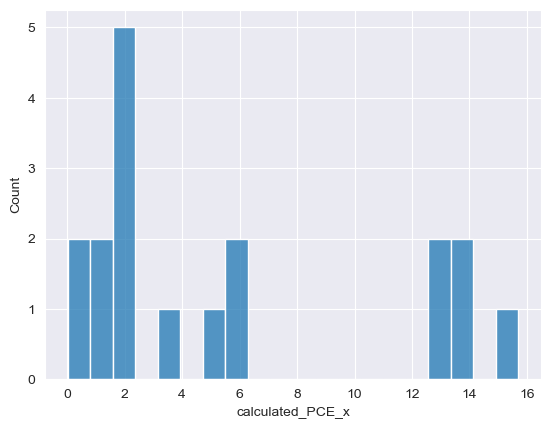

In [49]:
sns.histplot(data=common_outliers, x="calculated_PCE_x", bins=20)

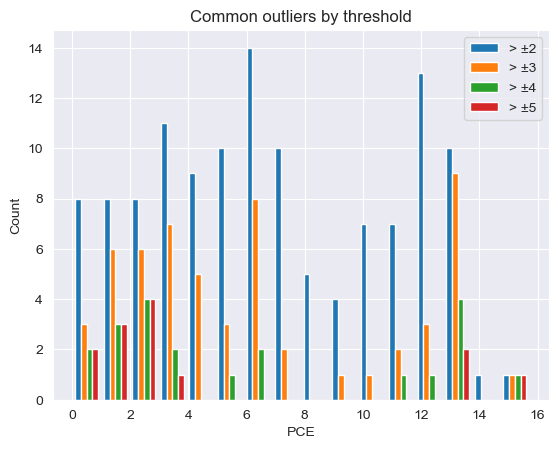

In [95]:
import matplotlib.pyplot as plt

plt.hist([outliers_df[2], outliers_df[3], outliers_df[4], outliers_df[5]], bins=16, label=["> ±2", "> ±3", "> ±4", "> ±5"])
plt.legend()
# X-axis label
plt.xlabel('PCE')
# frequency label
plt.ylabel('Count')
plt.title('Common outliers by threshold')
plt.show()

In [100]:
outliers_df[4]

0       3.841153
1      13.178127
2       3.121229
3       2.279024
4       4.936456
         ...    
121          NaN
122          NaN
123          NaN
124          NaN
125          NaN
Name: 4, Length: 126, dtype: float64